In [1]:
import glob
import re
import os

# import pickle5 as pickle
import matplotlib
# disable figure background
matplotlib.rcParams["figure.facecolor"] = (1.0, 0.0, 0.0, 0.0)
matplotlib.rcParams["savefig.facecolor"] = (0.0, 0.0, 0.0, 0.0)
matplotlib.rcParams["axes.facecolor"] = (1.0, 0.0, 0.0, 0.0)
matplotlib.rcParams["figure.dpi"] = 300
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import zarr
import xarray as xr
import numpy as np
import scipy.stats as st

import seaborn as sns
# sns.set_style("white")

In [2]:
# input_directory = "/data.nst/lucas/history_dependence/signatures_of_temporal_processing_paper_code/data/bn_code_cleaned/" # yy-mm-dd_hexid.zarr/
input_directory = "../dat/bn_times/" # yy-mm-dd_hexid.zarr.zip
spike_group = "/spikes_by_neuron"  # or spikes_as_list
figure_output_dir = "/data.nst/pspitzner/information_timescales/branching_network/fig/"


def get_dims_of_file(fname, dims_to_get="all"):
    file = zarr.open(fname + spike_group, mode="r")
    dims = dict()

    if dims_to_get == "all":
        dims_to_get = list(file.attrs.keys())

    for dim in dims_to_get:
        if dim in file.attrs:
            dims[dim] = file.attrs[dim]

    return dims


def get_files_for_dims(dims_to_check: dict):
    files = glob.glob(input_directory + "*.zarr*")
    files.sort()

    # get all files that match the coordinates
    matches = []
    for fname in files:
        dims = get_dims_of_file(fname, dims_to_check.keys())
        if all([dims_to_check.get(k, None) == dims[k] for k in dims]):
            matches.append(fname)

    return matches


matches = get_files_for_dims(
    {"N": 10000, "k": 100, "input_type": "OU", "m": 0.975, "rep": 0}
)
matches


In [ ]:
from numba import jit

@jit(nopython=True, parallel=True, fastmath=False, cache=True)
def binned_spike_count(spiketimes, bin_size, length=None):
    """
    Similar to `population_rate`, but we get a number of spike counts, per neuron
    as needed for e.g. cross-correlations.

    Parameters
    ----------
    spiketimes :
        np array with first dim neurons, second dim spiketimes. nan-padded
    bin_size :
        float, in units of spiketimes
    length :
        duration of output trains, in units of spiketimes. Default: None,
        uses last spiketime

    Returns
    -------
    counts : 2d array
        time series of the counted number of spikes per bin,
        one row for each neuron, in steps of bin_size
    """

    num_n = spiketimes.shape[0]

    if length is not None:
        num_bins = int(np.ceil(length / bin_size))
    else:
        t_min = 0.0
        t_max = np.nanmax(spiketimes)
        num_bins = int(np.ceil((t_max - t_min) / bin_size)) + 1

    counts = np.zeros(shape=(num_n, num_bins))

    for n_id in range(0, num_n):
        train = spiketimes[n_id]
        for t in train:
            if not np.isfinite(t):
                break
            t_idx = int(t / bin_size)
            counts[n_id, t_idx] += 1

    return counts

ylim for pop rate: (-0.3752206262127879, 3.752206262127879)
time scale bar for 1 seconds
ylim for pop rate: (-0.3752206262127879, 3.752206262127879)
time scale bar for 1 seconds
found 0 files for {'N': 1000, 'k': 10, 'input_type': 'OU', 'm': 0.95, 'rep': 0}, skipping
found 0 files for {'N': 1000, 'k': 10, 'input_type': 'constant', 'm': 0.95, 'rep': 0}, skipping
ylim for pop rate: (-0.5191369155107676, 5.191369155107676)
time scale bar for 1 seconds
ylim for pop rate: (-0.5191369155107676, 5.191369155107676)
time scale bar for 1 seconds


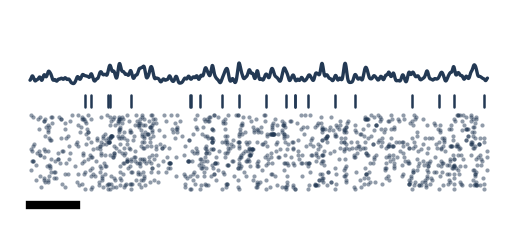

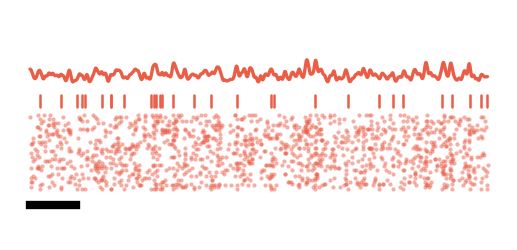

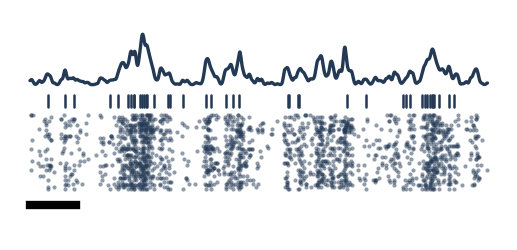

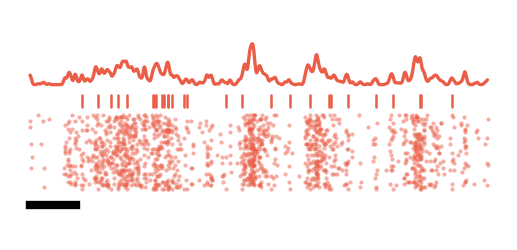

In [ ]:

rep = 0
t_max = 10  # seconds
focus_nid = 0
N_to_plot = 40 # we recorded 100 neurons
base_clrs={"OU": "#233954", "constant": "#EA5E48"}

# we want to have the same y-axis in all rate panels.
# run twice to auto-detectk, see printed output
if "pop_rate_ymax" not in globals():
    pop_rate_ymax = 0

for m in [0.8, 0.96545]:
    for input_type in ["OU", "constant"]:

        dims = dict(
            N=1000,
            k=10,
            input_type=input_type,
            m=m,
            rep=rep,
        )
        files = get_files_for_dims(dims)

        if len(files) != 1:
            print(f"found {len(files)} files for {dims}, skipping")
            continue

        file = zarr.open(files[0] + spike_group, mode="r")
        dt = file.attrs["dt"]

        assert spike_group == "/spikes_by_neuron" # not implemented the other format here

        spikes = [None] * N_to_plot
        for nid in range(N_to_plot):
            spikes[nid] = file[nid] * dt
            spikes[nid] = spikes[nid][spikes[nid] >= 0]
            spikes[nid] = spikes[nid][spikes[nid] <= t_max]
        # spikes are a ragged list
        spikes

        max_len = max([len(s) for s in spikes])
        spikes = np.array(
            [np.pad(s, (0, max_len - len(s)), constant_values=np.nan) for s in spikes]
        )

        cm = 1 / 2.54
        fig, axes = plt.subplots(
            nrows=3,
            sharex=True,
            figsize=(5 * cm, 1.8 * cm),
            gridspec_kw=dict(
                height_ratios=[1.5, 0.5, 2],
                hspace=0.01,
            ),
        )

        # population activity
        bin_size = 5 / 1000
        sn_act = binned_spike_count(spikes, bin_size=bin_size, length=t_max)
        pop_act = np.sum(sn_act, axis=0)
        # smooth it with a gaussian kernel
        from scipy.ndimage import gaussian_filter1d

        pop_act = gaussian_filter1d(pop_act, sigma=5)
        ax = axes[0]
        ax.plot(
            np.arange(len(pop_act)) * bin_size,
            pop_act,
            c=base_clrs[input_type],
            solid_capstyle="round",
            # we limited the datarange already before
            clip_on=False,
            lw=0.8,
        )
        pop_rate_ymax = max(pop_rate_ymax, np.max(pop_act)*1.1)
        ax.set_ylim(0 - pop_rate_ymax/10, pop_rate_ymax)
        print(f"ylim for pop rate: {ax.get_ylim()}")
        

        # sort neuron ids by correlation
        corr = np.corrcoef(sn_act)
        corr[np.isnan(corr)] = 0
        corr[np.isinf(corr)] = 0
        corr = np.abs(corr)
        corr[np.diag_indices_from(corr)] = 0
        corr = np.sum(corr, axis=0)
        sort_idx = np.argsort(corr)[::-1]
        spikes = spikes[sort_idx]

        # population raster
        ax.set_rasterization_zorder(0)
        for nid, spike_times in enumerate(spikes):
            ax = axes[2]
            ax.scatter(
                spike_times,
                np.ones_like(spike_times) * nid,
                s=1,
                lw=0,
                c=base_clrs[input_type],
                alpha=0.5,
                zorder=-1,
                clip_on=False,
            )
            if nid > 50:
                break



        # plot a single neuron raster a bit more clearly to show the micro strucutre
        ax = axes[1]
        for s in spikes[focus_nid]:
            ax.plot(
                [s, s],
                [0.2, 0.8],
                c=base_clrs[input_type],
                lw=0.6,
                solid_capstyle="round",
                alpha=1.0,
                clip_on=False,
            )
        ax.set_ylim(0, 1)

        # axes[2].set_ylabel("Neuron ID")
        # axes[2].set_xlabel("Time (s)")
        # create a time scale bar by making the spine fat and desping with seaborn
        t_2 = t_max
        t_delta = int(t_max / 10)
        print(f"time scale bar for {t_delta} seconds")
        axes[2].set_xticks([0, t_delta])
        axes[2].set_xlim(0, t_max)
        sns.despine(ax=axes[2], bottom=False, trim=True, offset=3)
        axes[2].set_xticks([])
        axes[2].spines["bottom"].set_linewidth(2)

        for ax in axes:
            ax.set_yticks([])
            ax.xaxis.set_visible(False)
            ax.spines["bottom"].set_visible(False)
            ax.spines["right"].set_visible(False)
            ax.spines["left"].set_visible(False)
            ax.spines["top"].set_visible(False)

        # renable time bar
        axes[2].spines["bottom"].set_visible(True)

        os.makedirs(figure_output_dir, exist_ok=True)
        dims.pop("rep")
        suffix = "_".join([f"{k}={v}" for k, v in dims.items()])
        suffix += f"_{t_max}s"
        fig.savefig(
            f"{figure_output_dir}/raster_examples_{suffix}.pdf",
            dpi=600,
            bbox_inches="tight",
        )
